In [1]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64
from collections import Counter
import igraph as ig
import leidenalg as la
from igraph import Graph, Plot
from igraph.drawing.text import TextDrawer
import cairo
from matplotlib import rcParams

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

rcParams['font.family'] = 'arial'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 2


In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
df_metabolites_reversed = df_metabolites.reset_index().set_index('newID')
df_microbes_reversed = df_microbes.reset_index().set_index('newID')
MAX_ID_metabolites = len(df_metabolites)
MAX_ID_microbes = len(df_microbes)

In [5]:
## Corrections for metabolite and microbial IDs when there is an error happens to them
'''
for i in range(0, 100):
    for j in range(len(df[i])):
        max_links = MAX_ID_metabolites * MAX_ID_microbes
        pos_x = df[i]['position in x'].iloc[j]
        edgeType = 2 + int(pos_x >= max_links)
        pos_x = pos_x - (edgeType - 2) * max_links
        row = pos_x // NumMicrobes
        col = pos_x - row * NumMicrobes

        metID = df_metabolites_reversed.loc[row].values[0]
        microbeID = df_microbes_reversed.loc[col].values[0]
        metName = names.loc[metID].values[0]
        microbeName = names.loc[microbeID].values[0]

        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]
        
for i in range(1, 101):
    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')
    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')
    
'''


"\nfor i in range(0, 100):\n    for j in range(len(df[i])):\n        max_links = MAX_ID_metabolites * MAX_ID_microbes\n        pos_x = df[i]['position in x'].iloc[j]\n        edgeType = 2 + int(pos_x >= max_links)\n        pos_x = pos_x - (edgeType - 2) * max_links\n        row = pos_x // NumMicrobes\n        col = pos_x - row * NumMicrobes\n\n        metID = df_metabolites_reversed.loc[row].values[0]\n        microbeID = df_microbes_reversed.loc[col].values[0]\n        metName = names.loc[metID].values[0]\n        microbeName = names.loc[microbeID].values[0]\n\n        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]\n        \nfor i in range(1, 101):\n    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')\n    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')\n    \n"

In [6]:
df = []
for i in range(1, 101):
    #df.append(pd.read_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv', index_col=0))
    df.append(pd.read_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv', index_col=0))

In [7]:
df_all = df[0].copy()
for i in range(1, len(df)):
    df_all = pd.concat([df_all, df[i]])
#df_all.set_index('position in x', inplace=True)
df_all.sort_values(['metabolite ID', 'microbes ID'])

metabolite ID                                   metabolite names  \
46            2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
135           2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
8             2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
17            2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
86            2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
106           2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
119           2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
120           2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
21            2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
147           2001  [R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...   
57            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
48            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
37            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
120           2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
13            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
89            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
134           2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
122           2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
39            2002  1,2-diacylglycerol (1-acylglycerol, Monoacylgl...   
85            2003                   1,2-Ethanediol (Ethylene glycol)   
68            2003                   1,2-Ethanediol (Ethylene glycol)   
134           2003                   1,2-Ethanediol (Ethylene glycol)   
40            2003                   1,2-Ethanediol (Ethylene glycol)   
20            2003                   1,2-Ethanediol (Ethylene glycol)   
6             2003                   1,2-Ethanediol (Ethylene glycol)   
39            2003                   1,2-Ethanediol (Ethylene glycol)   
137           2003                   1,2-Ethanediol (Ethylene glycol)   
81            2003                   1,2-Ethanediol (Ethylene glycol)   
34            2003                   1,2-Ethanediol (Ethylene glycol)   
4             2003                   1,2-Ethanediol (Ethylene glycol)   
..             ...                                                ...   
2             2242                          XOS (Xylooligosaccharide)   
4             2242                          XOS (Xylooligosaccharide)   
4             2242                          XOS (Xylooligosaccharide)   
3             2242                          XOS (Xylooligosaccharide)   
2             2242                          XOS (Xylooligosaccharide)   
54            2242                          XOS (Xylooligosaccharide)   
12            2242                          XOS (Xylooligosaccharide)   
73            2242                          XOS (Xylooligosaccharide)   
49            2242                          XOS (Xylooligosaccharide)   
36            2242                          XOS (Xylooligosaccharide)   
1             2242                          XOS (Xylooligosaccharide)   
1             2242                          XOS (Xylooligosaccharide)   
0             2242                          XOS (Xylooligosaccharide)   
2             2242                          XOS (Xylooligosaccharide)   
1             2242                          XOS (Xylooligosaccharide)   
14            2242                          XOS (Xylooligosaccharide)   
68            2242                          XOS (Xylooligosaccharide)   
16            2242                          XOS (Xylooligosaccharide)   
4             2242                          XOS (Xylooligosaccharide)   
104           2242                          XOS (Xylooligosaccharide)   
45            2242                          XOS (Xylooligosaccharide)   
112           2243                                            Xylitol   
106           2243                                            X

In [8]:
links_added = []
for i in range(len(df)):
    links_added.append(set(df[i]['position in x'].values))

## optimization trajectories

## Load functions

In [10]:
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.


f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

## Measure performance of one simulation

In [11]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
#netNUM = 0
netNUM = 53
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added])

corr_list = np.zeros((thai_metabolome.shape[1],2))
diet_list = np.zeros((thai_metabolome.shape[1], 20))
log_list = np.zeros((thai_metabolome.shape[1],2))
numMet_list = np.zeros((thai_metabolome.shape[1]))
metagenome_predicted = np.zeros((thai_metabolome.shape[1], thai_metagenome_ID.shape[0]))
metabolome_predicted = np.zeros((thai_metabolome.shape[1], thai_metabolome_ID.shape[0]))
for pa in range(thai_metabolome.shape[1]):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    
    metagenome_predicted[pa, :] = ba_pred[thai_metagenome_ID]
    metabolome_predicted[pa, :] = metabolome_pred[thai_metabolome_ID]
    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    numMet_list[pa] = i_common.shape[0]
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
#'''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(corr_list[:,1]))
print('Average log10 accuracy between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))
print('Average number of metabolites overlapped between predicted and experimentally measured metabolome:')
print(np.mean(numMet_list))
#'''
#corr_allreplicates.append(np.mean(corr_list[:,1]))
#log10_allreplicates.append(np.mean(log_list[:,1]))


/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:
0.769307826470807
Average log10 accuracy between predicted and experimentally measured metabolome:
0.5110612569845648
Average number of metabolites overlapped between predicted and experimentally measured metabolome:
30.634146341463413


In [39]:
#netNUM = 43#53
corr_traj_all = []
error_traj_all = []
for netNUM in range(len(df)):
    print(netNUM)
    net_added = df[netNUM].iloc[:, np.array([0,2,4])]
    net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
    net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
    net_added.columns = net.columns
    corr_traj = []
    error_traj = []
    numMet_traj = []

    for NumOfSubsetLinksAdded in range(len(net_added)+1):
        ######## Convert x to net structure:
        corr_allreplicates = []
        log10_allreplicates = []
        net_ori = net.copy()
        #netNUM = 0

        net_new = pd.concat([net_ori, net_added.iloc[:NumOfSubsetLinksAdded]])

        corr_list = np.zeros((thai_metabolome.shape[1],2))
        diet_list = np.zeros((thai_metabolome.shape[1], 20))
        log_list = np.zeros((thai_metabolome.shape[1],2))
        numMet_list = np.zeros((thai_metabolome.shape[1]))
        metagenome_predicted = np.zeros((thai_metabolome.shape[1], thai_metagenome_ID.shape[0]))
        metabolome_predicted = np.zeros((thai_metabolome.shape[1], thai_metabolome_ID.shape[0]))
        for pa in range(thai_metabolome.shape[1]):
            #print(pa)
            ######## Select an ID of a individual and pull out its experimentally measured metagenome:
            b_real = np.zeros((MAX_ID_microbes,))
            b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

            ######## Compute matrices involving the metabolite consumption and generation:
            m2b, b2m = Ain_out(b_real, net_new)
            #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
            m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

            ######## Assign diet
            x0 = np.ones((len(i_intake),)) / len(i_intake)

            ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
            # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
            # from the model for a certain nutrient intake.
            fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
            bnds = ((0, 100), ) * len(x0)
            res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

            ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
            # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
            # visually and statistically compared to the experimentally measured metagenome and metabolome.
            x_full = np.zeros((MAX_ID_metabolites,));
            x_full[i_intake] = res.x;
            ba_pred = np.dot(m2b_total, x_full)

            met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
            metabolome_measured = np.zeros((MAX_ID_metabolites,))
            metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
            metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
            i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
            metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
            metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

            metagenome_predicted[pa, :] = ba_pred[thai_metagenome_ID]
            metabolome_predicted[pa, :] = metabolome_pred[thai_metabolome_ID]
            corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
            #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
            corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
            log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
            log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
            diet_list[pa, :] = res.x
            numMet_list[pa] = i_common.shape[0]
            '''
            print('-------------------------------------------------------------------------------------------------------------')
            print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
            print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
            print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
            print(pearsonr(metabolome_pred_common, metabolome_measured_common))
            '''
        #'''
        #print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
        #print(np.mean(corr_list[:,1]))
        #print('Average log10 accuracy between predicted and experimentally measured metabolome:')
        #print(np.mean(log_list[:,1]))
        #print('Average number of metabolites overlapped between predicted and experimentally measured metabolome:')
        #print(np.mean(numMet_list))
        #print(NumOfSubsetLinksAdded, np.mean(corr_list[:,1]), np.mean(log_list[:,1]), np.mean(numMet_list))
        corr_traj.append(np.mean(corr_list[:,1]))
        error_traj.append(np.mean(log_list[:,1]))
        numMet_traj.append(np.mean(numMet_list))

    df_traj = pd.DataFrame.from_dict({'corr': corr_traj, 'error': error_traj, 'numMet': numMet_traj})
    df_traj.to_csv('./data/trajectory_'+str(netNUM)+'.csv')
    corr_traj_all.append(corr_traj)
    error_traj_all.append(error_traj)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


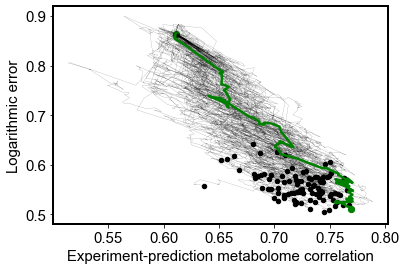

In [93]:
#plt.figure(figsize = (12,8))
for corr_traj, error_traj in zip(corr_traj_all, error_traj_all):
    plt.plot(corr_traj, error_traj, 'k', lw=0.1)
    plt.scatter(corr_traj[-1], error_traj[-1], s=20, color='k')
corr_traj = corr_traj_all[53]
error_traj = error_traj_all[53]
plt.plot(corr_traj, error_traj, 'g', lw=2.5)
plt.scatter(corr_traj[0], error_traj[0], s=40, color='g')
plt.scatter(corr_traj[-1], error_traj[-1], s=40, color='g')
plt.xlabel('Experiment-prediction metabolome correlation')
plt.ylabel('Logarithmic error')
#plt.xscale('log'); plt.yscale('log')
#plt.savefig('./figures/trajectories.png', dpi=600)
